# 1. Veri Seti ve Problem Tanımı

Bu sınıflandırma projesinde, hastaların kalp hastalığı olup olmadığını tahmin etmek için farklı yöntemler kullanarak yüksek doğruluklu bir makine öğrenmesi modeli oluşturulmaya çalışılmaktadır.

Kullanılacak veri seti UCI tarafından sağlanan Kalp Hastalığı veri setidir.

# 2. Özellikler

1. age
2. sex: (1 = male; 0 = female)
3. cp: (göğüs ağrısı tipi)
 * 0:Tipik anjina: göğüs ağrısına bağlı kalbe kan akışının azalması
 * 1:Atipik anjina: kalple ilgili olmayan göğüs ağrısı
 * 2:Anjina dışı ağrı: tipik olarak özofagus spazmları (kalple ilgili olmayan)
 * 3:Asemptomatik: hastalık belirtisi göstermeyen göğüs ağrısı
4. tretbps: dinlenme kan basıncı (hastaneye kabulde mm Hg cinsinden) 130-140'ın üzerinde herhangi bir şey genellikle endişe kaynağıdır.
5. chol: mg/dl cinsinden serum kolesterolü
 * serum = LDL + HDL + 0,2 * trigliseritler
 * 200'ün üstü endişe kaynağı
6. fbs: (açlık kan şekeri > 120 mg/dl) (1 = doğru; 0 = yanlış)
 * '>126' mg/dL diyabet sinyalidir
7. restecg: dinlenme elektrokardiyografik sonuçları
 * 0: Not edilecek bir şey yok
 * 1: ST-T Dalga anormalliği
   -Hafif semptomlardan ciddi sorunlara kadar değişebilir
   -normal olmayan kalp atışının sinyalini verir
 * 2: Olası veya kesin sol ventriküler hipertrofi
   -Genişlemiş kalbin ana pompalama odası
8. thalach: ulaşılan maksimum kalp atış hızı
9. exang: egzersize bağlı anjina (1 = evet; 0 = hayır)
10. oldpeak: Dinlenmeyle karşılaştırıldığında egzersizin neden olduğu ST depresyonu, egzersiz sırasında kalpteki strese bakar, sağlıksız kalp daha fazla strese neden olur
11. slope: zirve egzersiz ST segmentinin eğimi
  * 0: Yükseliş: egzersizle daha iyi kalp atış hızı (nadir)
  * 1: Düz eğimli: minimal değişiklik (tipik sağlıklı kalp)
  * 2: Downslopins: sağlıksız kalbin belirtileri
12. ca: florosopi ile renklendirilen ana damarların sayısı (0-3)
  * renkli damar, doktorun içinden geçen kanı görebileceği anlamına gelir
  * ne kadar çok kan hareketi olursa o kadar iyi (pıhtı olmaz)
13. thal: talyum stres sonucu
  * 1,3: normal
  * 6: Düzeltilen kusur: eskiden kusur vardı ama şimdi sorun yok
  * 7: geri döndürülebilir kusur: egzersiz sırasında uygun kan hareketi yok
14. target: hastalığın olup olmadığı (1=evet, 0=hayır) (tahmin edilen özellik)

# 3. Kütüphaneler ve Veri Setinin içe Aktarılması

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from sklearn.preprocessing import StandardScaler

In [2]:
df_ = pd.read_csv("/kaggle/input/heart-disease/heart.csv")
df = df_.copy()

In [3]:
df.shape

(303, 14)

Veri seti 303 satır 14 sütun içeriyor.

# Keşifsel veri analizi (EDA)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [6]:
df['target'].value_counts()

target
1    165
0    138
Name: count, dtype: int64

Veri setinde 165 hastada kalp hastalığı bulunuyor, 138 hastada ise kalp hastalığı bulunmuyor.

<Axes: xlabel='target'>

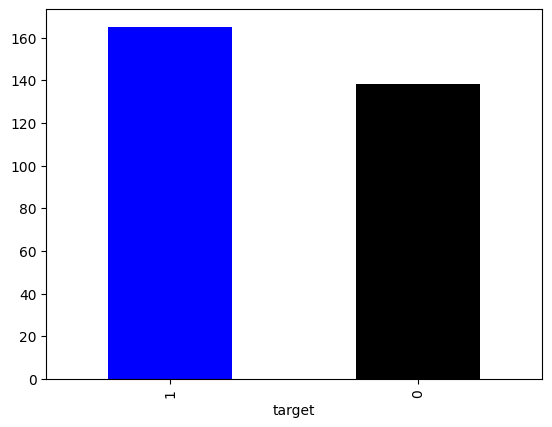

In [7]:
df['target'].value_counts().plot(kind = 'bar', color = ['blue', 'black'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Veri setinde eksik değerleri gözlemliyoruz ve tüm sütunlarda sayısal veri türleri bulunuyor.

In [9]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [10]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [11]:
df['sex'].value_counts()

sex
1    207
0     96
Name: count, dtype: int64

Cinsiyet sütununda 1 erkekleri 0 ise kadınları temsil ettiğinden veri setinde 207 erkek ve 96 kadın olduğunu görebiliriz. Hedef sütunla karşılaştırma yapalım.

In [12]:
pd.crosstab(df['target'],df['sex'])

sex,0,1
target,,
0,24,114
1,72,93


Karşılaştırmaya bakıldığında kadınlarda kalp hastalığı oranı erkeklere göre daha yüksek.

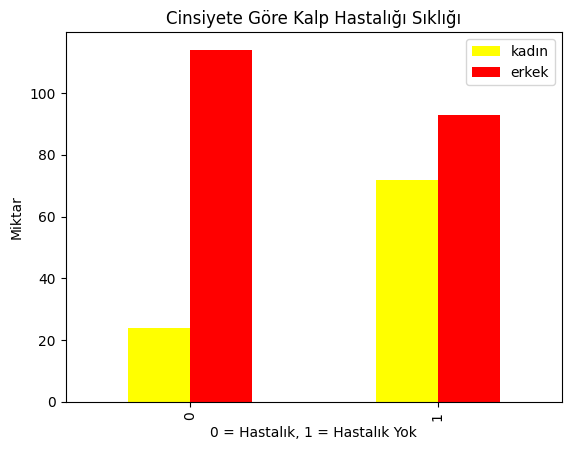

In [13]:
pd.crosstab(df['target'],df['sex']).plot(kind = 'bar', fig = (8,4), color = ['yellow', 'red'])
plt.title('Cinsiyete Göre Kalp Hastalığı Sıklığı')
plt.xlabel('0 = Hastalık, 1 = Hastalık Yok')
plt.ylabel('Miktar')
plt.legend(['kadın','erkek'])
plt.show()

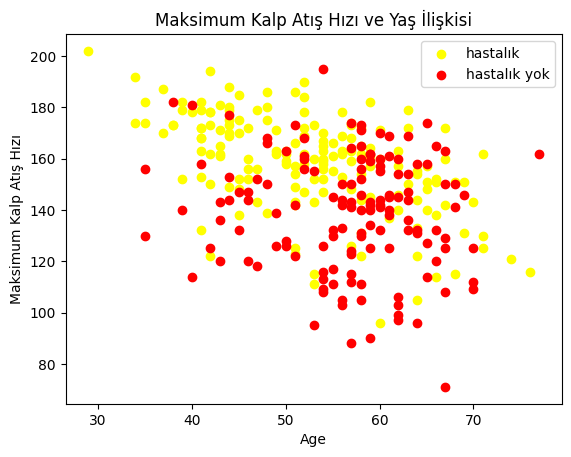

In [14]:
plt.scatter(df.age[df.target == 1],
           df.thalach[df.target == 1],
c = 'yellow')
plt.scatter(df.age[df.target == 0],
           df.thalach[df.target == 0],
           c = 'red')
plt.title('Maksimum Kalp Atış Hızı ve Yaş İlişkisi')
plt.xlabel('Age')
plt.ylabel('Maksimum Kalp Atış Hızı')
plt.legend(['hastalık', 'hastalık yok'])
plt.show()

In [16]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


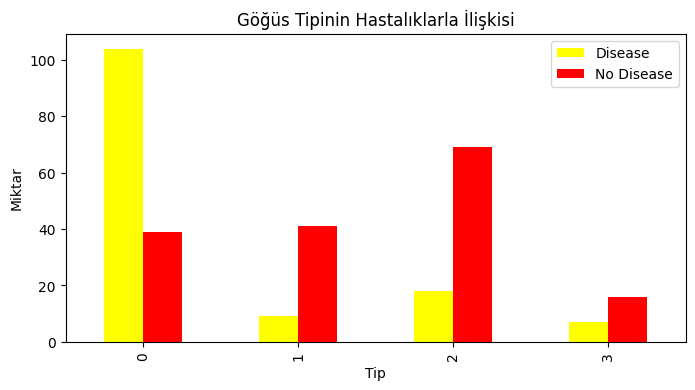

In [17]:
pd.crosstab(df.cp, df.target).plot(kind = 'bar', figsize = (8,4), color = ['yellow', 'red'])
plt.title('Göğüs Tipinin Hastalıklarla İlişkisi')
plt.xlabel('Tip')
plt.ylabel('Miktar')
plt.legend(['Disease','No Disease'])
plt.show()

In [18]:
import sys
print(sys.version)

3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


(14.5, -0.5)

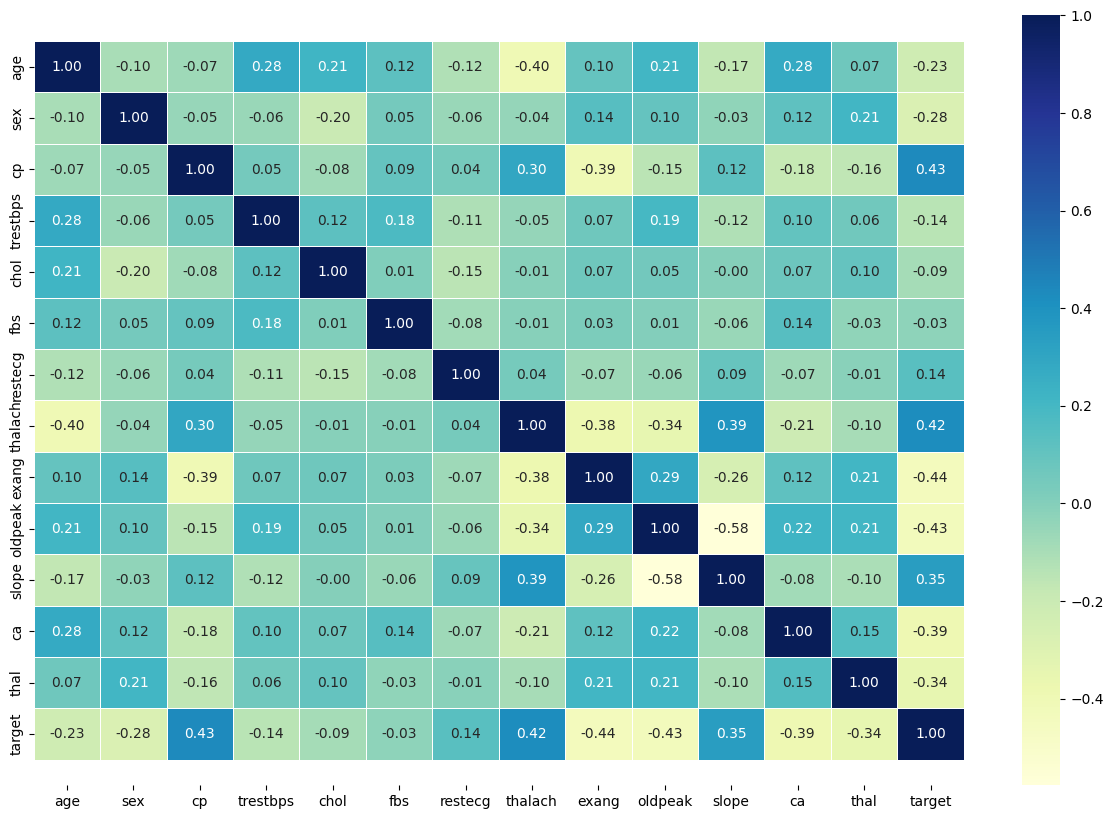

In [19]:
corr_matrix = df.corr()
fig ,ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap = 'YlGnBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Modelleme

In [20]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [22]:
x = df.drop(columns=['target'], axis = 1)
y = df['target']

In [23]:
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [24]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 20)

Verileri eğitim ve test kümelerine böldük. Verilerin %20 'sini test seti olarak belirledik. Sınıflandırma problemi olduğu için verilen parametreyi y olarak katmanlaştırdık. Aynı sonuçları elde etmek için random_state parametresine 20 değerini verdik.

In [26]:
len(y_train)

242

Model seçim sürecini değerlendirmek için bir işlem hattı oluşturabiliriz. Gridsearch ile farklı parametre değerlerine sahip 4 farklı makine öğrenmesi modeli deneyeceğiz. Çapraz doğrulama yöntemi olarak 5 bölmeli KFold (katmanlı) kullanacağız.

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier
4. Boosting Classifier


In [27]:
pipe = Pipeline([('scaler', StandardScaler()), ('Classifier', RandomForestClassifier())])
search_space = [
    {'Classifier': [LogisticRegression(solver='liblinear')],
     'Classifier__C': np.logspace(-4, 4, 100),
     'Classifier__penalty':['l1','l2']
    },
    {'Classifier': [KNeighborsClassifier()],
     'Classifier__n_neighbors':np.arange(1,10)
    },
    {'Classifier': [RandomForestClassifier(random_state=20)],
     'Classifier__n_estimators': [300,400,500],
     'Classifier__max_features': np.arange(1,10)
    },
    {'Classifier': [GradientBoostingClassifier(random_state=10)],
     'Classifier__n_estimators': [100, 500, 1000],
     'Classifier__learning_rate':[0.001,0.01,0.1]
    }
]
clf = GridSearchCV(pipe, search_space, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3), verbose=0, scoring='accuracy')
best_model = clf.fit(x_train, y_train)
best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('Classifier',
   LogisticRegression(C=0.1176811952434999, penalty='l1', solver='liblinear'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'Classifier': LogisticRegression(C=0.1176811952434999, penalty='l1', solver='liblinear'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'Classifier__C': 0.1176811952434999,
 'Classifier__class_weight': None,
 'Classifier__dual': False,
 'Classifier__fit_intercept': True,
 'Classifier__intercept_scaling': 1,
 'Classifier__l1_ratio': None,
 'Classifier__max_iter': 100,
 'Classifier__multi_class': 'auto',
 'Classifier__n_jobs': None,
 'Classifier__penalty': 'l1',
 'Classifier__random_state': None,
 'Classifier__solver': 'liblinear',
 'Classifier__tol': 0.0001,
 'Classifier__verbose': 0,
 'Classifier__warm_start': False}

Bu kod tüm süreci kapsar ve en iyi modelin yapılandırmasını kontrol etmeye yarar. GridSearch sonuçlarına göre en iyi modelin Lojistik Regresyon olduğu görülmektedir. Artık modeli, verilen C=0,1176811952434999 parametre değeriyle y değerlerini tahmin etmek için deneyebiliriz.

In [28]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [29]:
model = LogisticRegression(C=0.1176811952434999, penalty='l1', solver='liblinear')
model.fit(x_train_scaled, y_train)

LogisticRegression(C=0.1176811952434999, penalty='l1', solver='liblinear')

In [30]:
y_preds = model.predict(x_test_scaled)

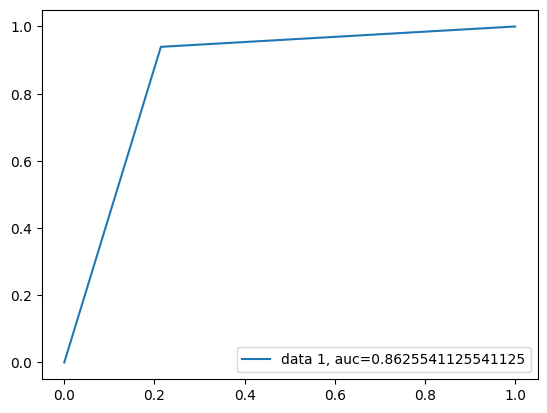

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_preds)
auc = roc_auc_score(y_test, y_preds)
plt.plot(fpr, tpr, label = 'data 1, auc=' + str(auc))
plt.legend(loc = 4)
plt.show()

In [32]:
print(confusion_matrix(y_test, y_preds))

[[22  6]
 [ 2 31]]


In [33]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.84      0.94      0.89        33

    accuracy                           0.87        61
   macro avg       0.88      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61



Model, pozitif sınıfı (1) oldukça iyi tahmin ederken, negatif sınıfı (0) için bazı yanlış tahminler yapmıştır. Genel olarak, modelin performansı iyi görünmektedir.

In [34]:
model.coef_

array([[-0.04630723, -0.35878607,  0.48575335, -0.04556522,  0.        ,
         0.        ,  0.04714513,  0.43750217, -0.21572551, -0.41967849,
         0.06883177, -0.48974944, -0.30805306]])

model.coef_, modelin karar verme sürecini anlamak ve hangi özelliklerin daha önemli olduğunu değerlendirmek için kullanılır. 0.04632227, -0.3587711, -0.04557311 gibi değerler, bu özelliklerin pozitif sınıfı azaltma eğiliminde olduğunu gösterir. 0.48575883, 0.04714858 gibi değerler ise bu özelliklerin pozitif sınıfı artırma eğiliminde olduğunu gösterir. 0. değerleri, ilgili özelliklerin modelin tahminlerine hiçbir katkı sağlamadığını ifade eder. Yani, bu özellikler model tarafından dikkate alınmamıştır.

In [35]:
feature_dict = dict(zip(df.columns, list(model.coef_[0])))
feature_dict

{'age': -0.04630723266058207,
 'sex': -0.35878606974004934,
 'cp': 0.48575335455549534,
 'trestbps': -0.04556522358992733,
 'chol': 0.0,
 'fbs': 0.0,
 'restecg': 0.04714513493556878,
 'thalach': 0.43750216970590816,
 'exang': -0.21572551057669404,
 'oldpeak': -0.4196784885390738,
 'slope': 0.06883176848942711,
 'ca': -0.4897494420793077,
 'thal': -0.3080530567900409}

Hangi özelliklerin pozitif veya negatif yönde daha etkili olduğu görülmektedir.

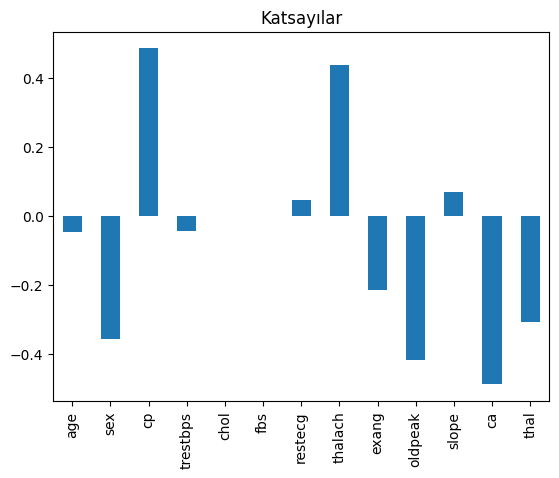

In [36]:
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Katsayılar", legend=False);

Bu görselleştirme, hangi özelliklerin model için daha önemli olduğunu hızlıca anlamanızı sağlar.